In [1]:
!pip install jcopdl
!pip install gdown

  Created wheel for jcopdl: filename=jcopdl-1.1.6-py2.py3-none-any.whl size=14997 sha256=317c3603b4dd875ab71e8919ae24ac96da3f21bd270b52b9b7d4f78fc872423d
  Stored in directory: /root/.cache/pip/wheels/b9/df/01/c6a98231c0e47cd56410c79ee431ac74541aff581489e6ca07
Successfully built jcopdl


In [2]:
!gdown https://drive.google.com/uc?id=1aPgQGEWnekL4MwhfoQIUUs8m2cT1Coon
    
    https://drive.google.com/uc?id=1-BLlCkouiJwwbKlmDNRVy1UF33XKBIDZ

Downloading...
From: https://drive.google.com/uc?id=1aPgQGEWnekL4MwhfoQIUUs8m2cT1Coon
To: /content/panorama.zip
25.7MB [00:00, 97.2MB/s]


In [3]:
!unzip /content/panorama.zip

Archive:  /content/panorama.zip
   creating: data/
  inflating: data/test_label.csv     
  inflating: data/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._.DS_Store  
   creating: data/test/
  inflating: data/test/1409.jpg      
   creating: __MACOSX/data/test/
  inflating: __MACOSX/data/test/._1409.jpg  
  inflating: data/test/1347.jpg      
  inflating: __MACOSX/data/test/._1347.jpg  
  inflating: data/test/1145.jpg      
  inflating: __MACOSX/data/test/._1145.jpg  
  inflating: data/test/360.jpg       
  inflating: __MACOSX/data/test/._360.jpg  
  inflating: data/test/1192.jpg      
  inflating: __MACOSX/data/test/._1192.jpg  
  inflating: data/test/374.jpg       
  inflating: __MACOSX/data/test/._374.jpg  
  inflating: data/test/1964.jpg      
  inflating: __MACOSX/data/test/._1964.jpg  
  inflating: data/test/1958.jpg      
  inflating: __MACOSX/data/test/._1958.jpg  
  inflating: data/test/572.jpg       
  inflating: __MACOSX/da

In [4]:
import jcopdl
jcopdl.__version__

'1.1.6'

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Ref mobilenet
https://pytorch.org/hub/pytorch_vision_mobilenet_v2/

## Dataset & Dataloader

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [8]:
bs = 64
crop_size = 224

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.7, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [9]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

## Aristektur & Config

### Contoh cara pakai Pretrained-Model

In [10]:
from torchvision.models import mobilenet_v2

In [11]:
mnet = mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [12]:
for param in mnet.parameters():
    param.requires_grad = False

In [13]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [14]:
mnet.classifier = nn.Sequential(
    nn.Linear(1280, 5),
    nn.Sigmoid()
)

In [15]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [16]:
class CustomMovilenetV2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.mnet = mobilenet_v2(pretrained=True)
        self.freeze()
        self.mnet.classifier = nn.Sequential(
            nn.Linear(1280, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.mnet(x)
        
    def freeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.mnet.parameters():
            param.requires_grad = True

In [17]:
config = set_config({
    "output_size": len(train_set.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

## Phase 1:Adaptation (lr standard + patience kecil)

In [18]:
model = CustomMovilenetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [19]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 0.4754 | Test_cost  = 0.3630 | 




Epoch     2
Train_cost  = 0.3390 | Test_cost  = 0.2989 | 




Epoch     3
Train_cost  = 0.2980 | Test_cost  = 0.2747 | 




Epoch     4
Train_cost  = 0.2718 | Test_cost  = 0.2586 | 




Epoch     5
Train_cost  = 0.2534 | Test_cost  = 0.2471 | 




Epoch     6
Train_cost  = 0.2513 | Test_cost  = 0.2382 | 




Epoch     7
Train_cost  = 0.2306 | Test_cost  = 0.2333 | 




Epoch     8
Train_cost  = 0.2354 | Test_cost  = 0.2271 | 




Epoch     9
Train_cost  = 0.2221 | Test_cost  = 0.2223 | 




Epoch    10
Train_cost  = 0.2266 | Test_cost  = 0.2179 | 




Epoch    11
Train_cost  = 0.2145 | Test_cost  = 0.2207 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2179




Epoch    12
Train_cost  = 0.2166 | Test_cost  = 0.2255 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2179
==> Execute Early Stopping at epoch: 12 | Best test_cost: 0.2179
==> Best model is saved at model


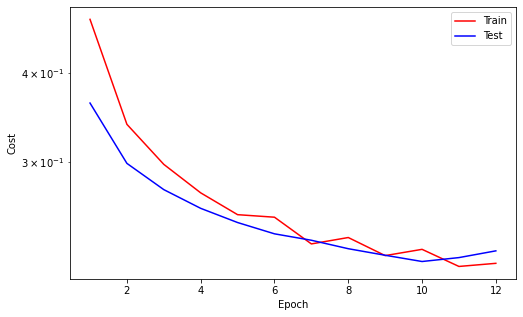

In [20]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Phase 2 : Fine-tuning (lr dikecilin, patience ditambah)

In [21]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
callback.reset_early_stop()
callback.early_stop_patience = 5



Epoch    13
Train_cost  = 0.2023 | Test_cost  = 0.2057 | 




Epoch    14
Train_cost  = 0.1838 | Test_cost  = 0.2026 | 




Epoch    15
Train_cost  = 0.1753 | Test_cost  = 0.1900 | 




Epoch    16
Train_cost  = 0.1692 | Test_cost  = 0.1865 | 




Epoch    17
Train_cost  = 0.1564 | Test_cost  = 0.1841 | 




Epoch    18
Train_cost  = 0.1525 | Test_cost  = 0.1886 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1841




Epoch    19
Train_cost  = 0.1473 | Test_cost  = 0.1803 | 




Epoch    20
Train_cost  = 0.1353 | Test_cost  = 0.1719 | 


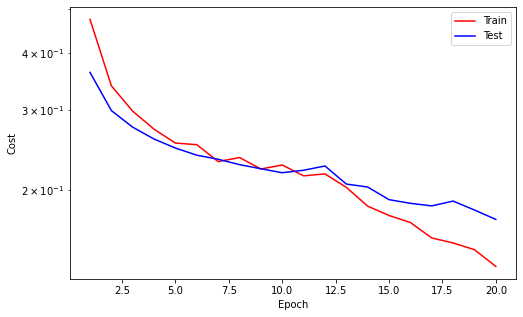



Epoch    21
Train_cost  = 0.1309 | Test_cost  = 0.1728 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1719




Epoch    22
Train_cost  = 0.1307 | Test_cost  = 0.1747 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1719




Epoch    23
Train_cost  = 0.1291 | Test_cost  = 0.1711 | 




Epoch    24
Train_cost  = 0.1203 | Test_cost  = 0.1722 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1711




Epoch    25
Train_cost  = 0.1162 | Test_cost  = 0.1644 | 




Epoch    26
Train_cost  = 0.1134 | Test_cost  = 0.1665 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1644




Epoch    27
Train_cost  = 0.1083 | Test_cost  = 0.1603 | 




Epoch    28
Train_cost  = 0.1108 | Test_cost  = 0.1657 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1603




Epoch    29
Train_cost  = 0.1045 | Test_cost  = 0.1620 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1603




Epoch    30
Train_cost  = 0.1045 | Test_cost  = 0.1583 | 




Epoch    31
Train_cost  = 0.0980 | Test_cost  = 0.1571 | 




Epoch    32
Train_cost  = 0.0995 | Test_cost  = 0.1574 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1571




Epoch    33
Train_cost  = 0.0932 | Test_cost  = 0.1569 | 




Epoch    34
Train_cost  = 0.0927 | Test_cost  = 0.1657 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1569




Epoch    35
Train_cost  = 0.0865 | Test_cost  = 0.1609 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1569




Epoch    36
Train_cost  = 0.0857 | Test_cost  = 0.1579 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1569




Epoch    37
Train_cost  = 0.0850 | Test_cost  = 0.1575 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1569




Epoch    38
Train_cost  = 0.0817 | Test_cost  = 0.1558 | 




Epoch    39
Train_cost  = 0.0779 | Test_cost  = 0.1595 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1558




Epoch    40
Train_cost  = 0.0755 | Test_cost  = 0.1577 | 


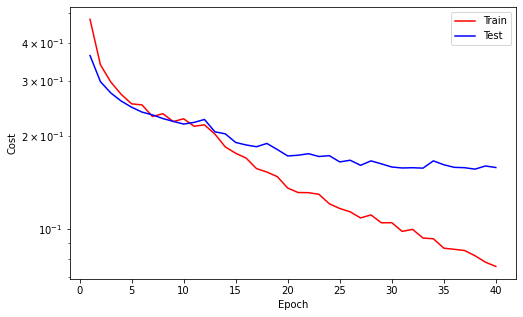

==> EarlyStop patience =  2 | Best test_cost: 0.1558




Epoch    41
Train_cost  = 0.0745 | Test_cost  = 0.1542 | 




Epoch    42
Train_cost  = 0.0729 | Test_cost  = 0.1522 | 




Epoch    43
Train_cost  = 0.0699 | Test_cost  = 0.1548 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1522




Epoch    44
Train_cost  = 0.0695 | Test_cost  = 0.1686 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1522




Epoch    45
Train_cost  = 0.0687 | Test_cost  = 0.1555 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1522




Epoch    46
Train_cost  = 0.0608 | Test_cost  = 0.1511 | 




Epoch    47
Train_cost  = 0.0617 | Test_cost  = 0.1506 | 




Epoch    48
Train_cost  = 0.0602 | Test_cost  = 0.1591 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1506




Epoch    49
Train_cost  = 0.0599 | Test_cost  = 0.1493 | 




Epoch    50
Train_cost  = 0.0612 | Test_cost  = 0.1562 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1493




Epoch    51
Train_cost  = 0.0570 | Test_cost  = 0.1531 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1493




Epoch    52
Train_cost  = 0.0565 | Test_cost  = 0.1561 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1493




Epoch    53
Train_cost  = 0.0529 | Test_cost  = 0.1551 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1493




Epoch    54
Train_cost  = 0.0558 | Test_cost  = 0.1576 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1493
==> Execute Early Stopping at epoch: 54 | Best test_cost: 0.1493
==> Best model is saved at model


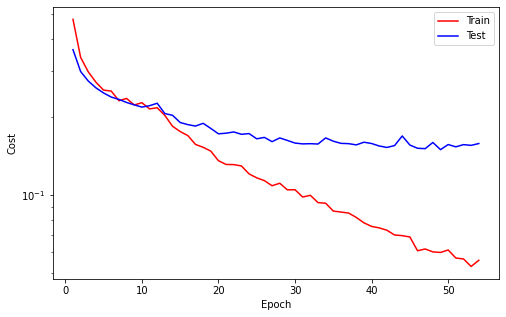

In [22]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Predict

In [23]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)


In [24]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = (output > 0.5).to(torch.float32)
preds

tensor([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0

## Sanity Check

In [25]:
def convert_to_label(x):
    return [label for pred, label in zip(x, label2cat) if pred == 1]

def inverse_norm(img):
    img[0, :, :] = img[0, :, :] * 0.229 + 0.485
    img[1, :, :] = img[1, :, :] * 0.224 + 0.456
    img[2, :, :] = img[2, :, :] * 0.225 + 0.406
    return img

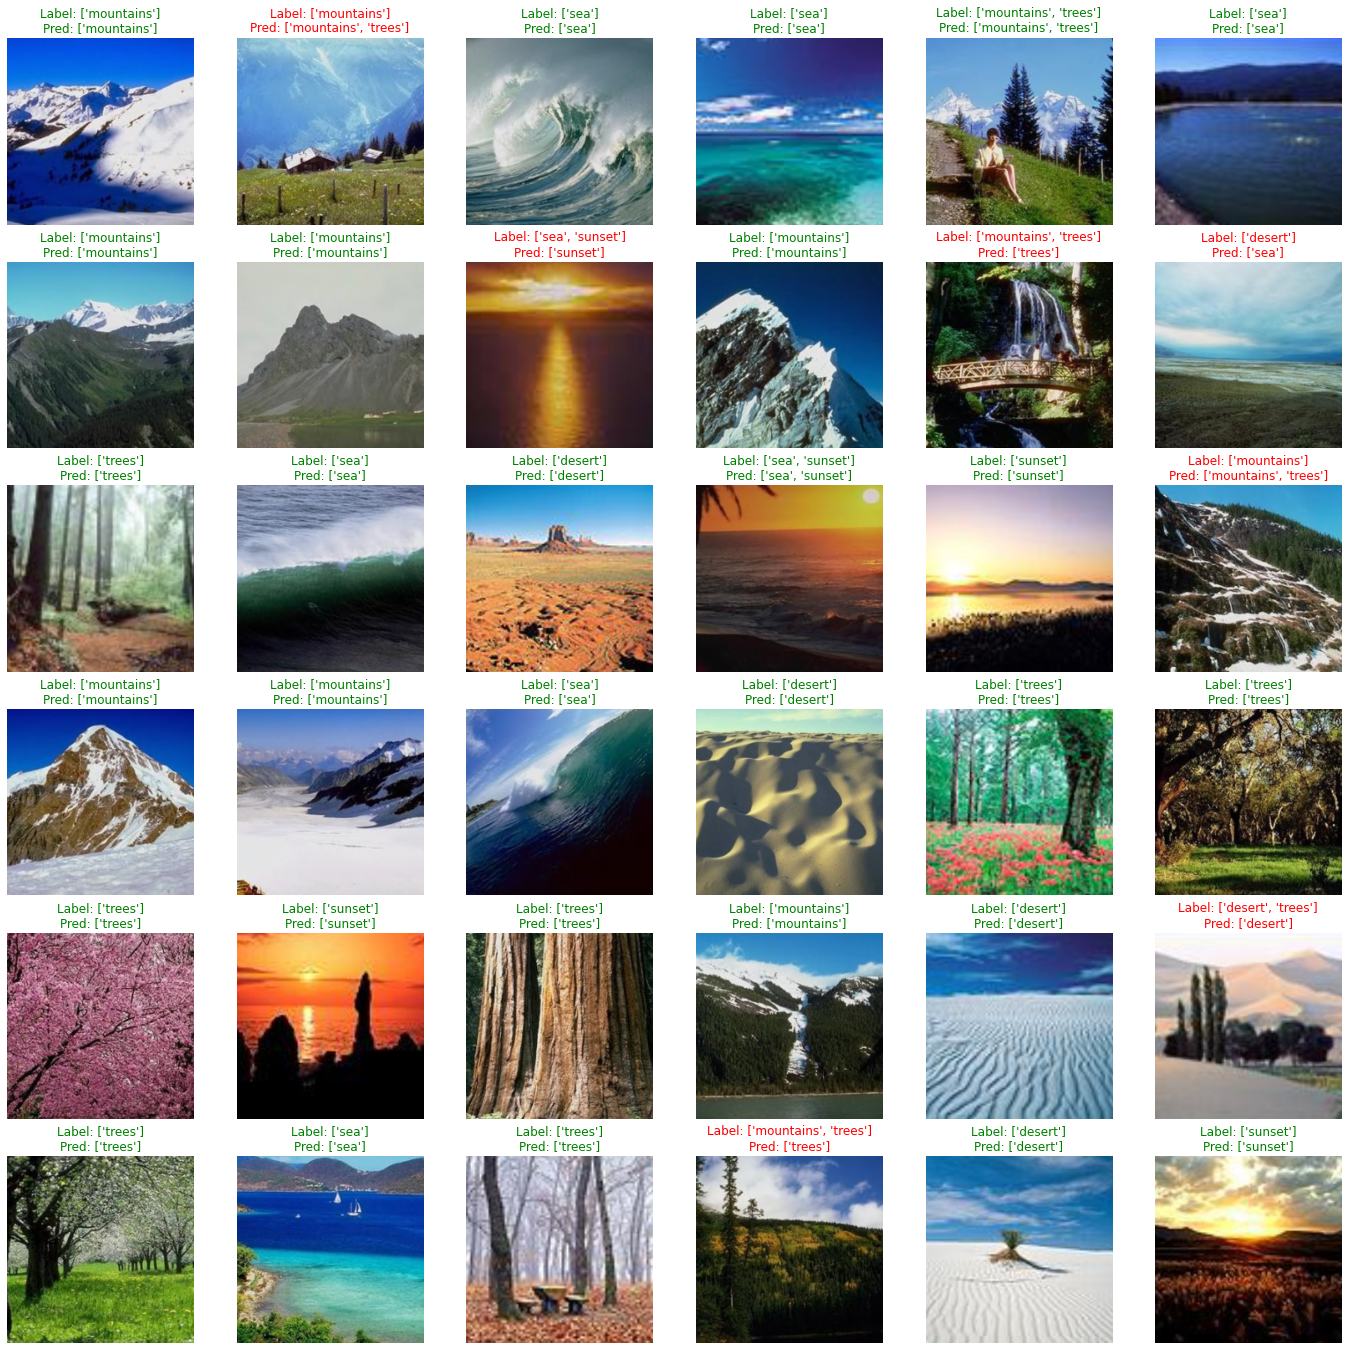

In [26]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": 'r'} if (pred != label).any() else {"color": 'g'}
    label, pred = convert_to_label(label), convert_to_label(pred)
    ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
    ax.axis('off');

In [27]:
!zip -r model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/weights_best.pth (deflated 8%)
  adding: content/model/logs.pth (deflated 9%)
  adding: content/model/weights_50.pth (deflated 8%)
  adding: content/model/configs.pth (deflated 13%)
